In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# from nltk.tokenize import word_tokenize as wt 
# from collections import Counter
import gensim
# import textblob
import spacy

## **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - Doc2Vec
- Begin modelling
    - Algorithms to use;
        - k-Nearest Neighbors.
        - Decision Trees.
        - Random Forest.
        - Gradient Boosting.
        - Logistic Regression
- Evaluation;
    - F1-score_macro
    - AUC
    - ROC

In [2]:
df_clean = pd.read_csv('../../../../cleaned_reviews.csv')

In [3]:
df_clean.shape

(17340, 4)

In [4]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [5]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

Checking for Null Vaules and Duplicates

In [6]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [7]:
df_clean.dropna(inplace=True)

In [8]:
df_clean.shape

(17337, 2)

In [9]:
from spacy.lang.en.stop_words import STOP_WORDS

# print(STOP_WORDS,'\n') # <- set of Spacy's default stop words
all_stopwords = STOP_WORDS
# Adding several stopwords
# all_stopwords |= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against'}

# Removing several stop words
all_stopwords-= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against','off','against','too'}
my_stop_words = set(all_stopwords) # My own stop words

In [10]:
# print(my_stop_words)

In [11]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

In [14]:
df_clean['tokens']= df_clean['cleaned_review'].apply(spacy_tokeniser)

In [15]:
df_clean.head()

,sentiments,cleaned_review,tokens
0,positive,i wish would have gotten one earlier love it a...,"[wish, get, early, love, make, work, laptop, e..."
1,neutral,i ve learned this lesson again open the packag...,"[ve, learn, lesson, open, package, use, produc..."
2,neutral,it is so slow and lags find better option,"[slow, lag, find, well, option]"
3,neutral,roller ball stopped working within months of m...,"[roller, ball, stop, work, month, minimal, use..."
4,neutral,i like the color and size but it few days out ...,"[like, color, size, day, return, period, not, ..."


In [16]:
# Dropping unnecessary columns
df_clean.drop(columns=['cleaned_review'],inplace=True)

Sentiment Mapping

In [17]:
sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)

In [18]:
df_clean.drop(columns=['sentiments'],inplace=True)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,cross_val_score

# The algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [20]:
df_clean.columns

Index(['tokens', 'sentiment_label'], dtype='object')

In [21]:
train, test = train_test_split(df_clean,test_size=.2,random_state=42, 
                                            stratify=df_clean.sentiment_label)

In [22]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [23]:
# Tagging the train ad test set

# Tag train set 
tagged_train = train.apply(
    lambda x: TaggedDocument(words=x["tokens"],tags=[x.sentiment_label]),
    axis=1
)

# Tag test set 
tagged_test = test.apply(
    lambda x: TaggedDocument(words=x["tokens"],tags=[x.sentiment_label]),
    axis=1
)

In [24]:
# looking into the tags
tagged_train.values[0]

TaggedDocument(words=['pair', 'headphone', 'work', 'plan', 'buy', 'pair', 'current', 'pair', 'gotten', 'damage', 'put', 'pair', 'uneven', 'surface', 'wire', 'tug', 'too', 'knock', 'head', 'phone', 'accident', 'time', 'walk', 'wear', 'head', 'phone', 'drop', 'phone', 'cord', 'got', 'accidentally', 'tug', 'unplugged', 'phone', 'won', 'headphone', 'outside', 'room', 'anymore', 'room', 'organize', 'shouldn', 'end', 'knock', 'accident', 'anymore'], tags=[-1])

In [25]:
tagged_test.values[0]

TaggedDocument(words=['break', 'right', 'run', 'return', 'window', 'came', 'narrow', 'move', 'link', 'event', 'not', 'don', 'know', 'problem'], tags=[-1])

### **Setting up DOC2VEC**

In [26]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores # Mine is 8 cores
four_cores = cores-4
four_cores

4

### **Building the Vocabulary**

In [27]:
# dm=1, it signifies PV-DM
model_dm = Doc2Vec(
    dm=1,
    vector_size=200,
    min_count=2,
    sample=0,
    workers=four_cores,
    hs=0,
    seed= 42,
    negative=5,
    alpha=0.5,# Changing alpha from 0.05 to 0.5
    dm_mean=1 # to make use of mean
)

In [28]:
model_dm.build_vocab(tagged_train)

In [29]:
# Word Apperance Count
def word_count(word:str):
    print(f"Word {word} appeared {model_dm.wv.get_vecattr(word, 'count')} times in the training corpus.")


word_count("terrible")

Word terrible appeared 130 times in the training corpus.


In [30]:
# Next, train the model on the corpus.
# Setting alpha
model_dm.train(
                tagged_train,
                total_examples=model_dm.corpus_count,
                epochs=100,
)

In [31]:
# checking the alpha value
model_dm.alpha

0.5

In [32]:
# Saving the model
# model_dm.save("pv_dm_200.model")

In [33]:
# https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    y, X = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=100)) for doc in sents])
    return X,y

In [34]:
X_train, y_train = vec_for_learning(model_dm, tagged_train)
X_test, y_test = vec_for_learning(model_dm, tagged_test)

In [35]:
print(X_train[:2])
print(y_train[:2])

(array([ 0.560848  ,  0.7396464 ,  1.5291418 , -1.7899228 ,  0.12598412,
       -0.50469387,  0.47488895,  0.78512585, -0.25306186, -0.57506794,
        0.29077077, -0.27785018,  1.0881014 , -0.12902848,  0.27253774,
       -0.39503106, -0.202881  , -0.85643613,  0.6925381 ,  0.7692768 ,
       -0.81587267, -0.9854027 ,  0.52732676,  0.02465752,  0.85926193,
        0.36128813, -0.33416924, -0.40395674,  0.23771416, -0.30152336,
       -0.17809166, -0.41489086,  0.11509823, -0.91848844, -0.40059873,
        0.8565714 , -0.05248904, -0.27169028, -0.75317657,  0.8535136 ,
        0.34060073,  0.01707966,  0.17941004,  0.43641677,  1.0204159 ,
        0.8888365 ,  0.16715448,  0.03920101,  1.5375282 ,  0.21364474,
        0.9666981 , -0.7261964 ,  0.02242379,  0.11926001,  0.35333046,
       -0.03211499,  0.04859044, -0.14487262, -0.7794133 , -0.21135207,
        1.0818685 , -0.6807142 , -0.39333475,  0.01350848, -0.23178536,
       -0.2685821 , -0.02668228, -0.97379404,  0.04669901, -0.4

In [36]:
models = {
    "DT": DecisionTreeClassifier(max_depth=3,random_state=42),
    "RF": RandomForestClassifier(max_depth=3,random_state=42),
    "GB": GradientBoostingClassifier(max_depth=3,random_state=42),
    "KNN": KNeighborsClassifier(),
    # "MNB": MultinomialNB(),
    "LR": LogisticRegression(multi_class='multinomial',solver='lbfgs'),
    "HGB": HistGradientBoostingClassifier(max_depth=3,random_state=42)
}

In [37]:
model_results_f1_macro = []
model_names = []
model_mean = []

In [38]:
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42) # 10% for validation 
scoring = 'f1_macro'
for name, model in models.items():
    model_names.append(name) # append each name of the model
    print(model) # print the model name for checks
    cv_results = cross_val_score(model,X_train,y_train,scoring=scoring,cv=my_cv,n_jobs=-2) 
    cv_results_list = cv_results.tolist() # Turning the array to a list
    model_results_f1_macro.append(cv_results_list) # append validation results
    model_mean.append(cv_results.mean()) # append the mean

DecisionTreeClassifier(max_depth=3, random_state=42)
RandomForestClassifier(max_depth=3, random_state=42)
GradientBoostingClassifier(random_state=42)
KNeighborsClassifier()
LogisticRegression(multi_class='multinomial')
HistGradientBoostingClassifier(max_depth=3, random_state=42)


In [39]:
print(model_results_f1_macro)
print(model_names)
print(model_mean)

[[0.3251779955282165, 0.34481658692185, 0.33562644019435384, 0.3423976245177592, 0.3336828445122741], [0.25553330700782656, 0.2703908357236153, 0.2522061389259887, 0.23884328232154317, 0.28388047559032015], [0.35952312983429174, 0.3667401238761736, 0.3696517468712299, 0.3650600840228968, 0.37856185129374526], [0.39873694223815787, 0.3796442272580188, 0.3847481963616913, 0.4138178629893064, 0.3817948033062939], [0.2498299025543447, 0.2543669829087162, 0.2432883340977221, 0.24307128104596457, 0.24953554802965863], [0.3579474740745914, 0.352948390043286, 0.3554765343787973, 0.3818949347519058, 0.37160452965122365]]
['DT', 'RF', 'GB', 'KNN', 'LR', 'HGB']
[0.33634029833489076, 0.26017080791385877, 0.3679073871796675, 0.39174840643069364, 0.24801840972728123, 0.3639743725799608]


In [40]:
# Creating a Dictionary of results
f1score_result_dict = dict(zip(model_names,model_results_f1_macro))
f1score_mean_dict = dict(zip(model_names,model_mean))

In [41]:
# Creating a Dataframe of results
f1score_result_frame = pd.DataFrame(f1score_result_dict)
f1score_mean_frame = pd.Series(f1score_mean_dict).to_frame('mean_f1_score').reset_index()
f1score_mean_frame.rename(columns={'index':'models'},inplace=True)

In [42]:
f1score_result_frame

,DT,RF,GB,KNN,LR,HGB
0,0.325178,0.255533,0.359523,0.398737,0.249830,0.357947
1,0.344817,0.270391,0.366740,0.379644,0.254367,0.352948
2,0.335626,0.252206,0.369652,0.384748,0.243288,0.355477
3,0.342398,0.238843,0.365060,0.413818,0.243071,0.381895
4,0.333683,0.283880,0.378562,0.381795,0.249536,0.371605


In [43]:
f1score_result_frame.to_csv("validation_doc2vec_200/doc2vec_f1score_results.csv",index=False)

In [44]:
f1score_mean_frame.sort_values(by='mean_f1_score',ascending=False)

,models,mean_f1_score
3,KNN,0.391748
2,GB,0.367907
5,HGB,0.363974
0,DT,0.336340
1,RF,0.260171
4,LR,0.248018


In [45]:
f1score_mean_frame.to_csv("validation_doc2vec_200/doc2vec_f1score_mean_results.csv")

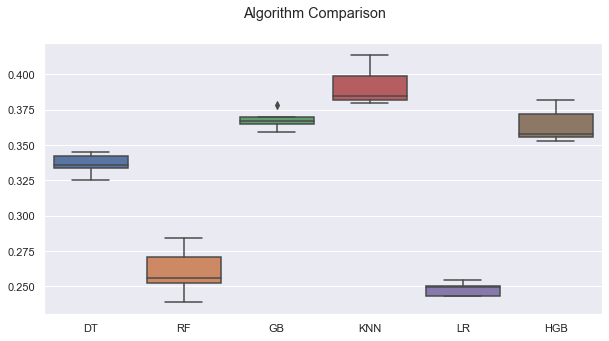

In [46]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=f1score_result_frame)
ax.set_xticklabels(model_names)
fig.suptitle('Algorithm Comparison')
plt.show()

Based off the plot above, the top three algorithms are;
1. KNN
2. GradientBoostingClassifier
3. HistGradientBoostingClassifier

In [47]:
from sklearn.model_selection import GridSearchCV

In [48]:
# Without PCA
pipe = Pipeline([('clf',KNeighborsClassifier())])

In [49]:
paramter_grid = {
                'clf__n_neighbors':[2,3,4,5,6],
                'clf__weights':["uniform", "distance"],
                'clf__leaf_size':[10,20,30],
                'clf__p':[1,2],
                }
my_cv = StratifiedShuffleSplit(n_splits=5,test_size=.1,random_state=42)

In [50]:
mygrid = GridSearchCV(pipe,param_grid=paramter_grid,cv=my_cv,scoring='f1_macro')
mygrid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.1,
            train_size=None),
             estimator=Pipeline(steps=[('clf', KNeighborsClassifier())]),
             param_grid={'clf__leaf_size': [10, 20, 30],
                         'clf__n_neighbors': [2, 3, 4, 5, 6], 'clf__p': [1, 2],
                         'clf__weights': ['uniform', 'distance']},
             scoring='f1_macro')

In [51]:
print(f"Best params: {mygrid.best_params_}\n")
print(f"Best estimator: {mygrid.best_estimator_}\n")
print(f"Best validation score: {mygrid.best_score_}")

Best params: {'clf__leaf_size': 10, 'clf__n_neighbors': 6, 'clf__p': 2, 'clf__weights': 'distance'}

Best estimator: Pipeline(steps=[('clf',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=6,
                                      weights='distance'))])

Best validation score: 0.4787767981995706


In [52]:
mygrid_trainset = mygrid.best_estimator_
mygrid_trainset

# KNeighborsClassifier(leaf_size=10, n_neighbors=6,
#                                       weights='distance')

# Best validation score: 0.4787767981995706

Pipeline(steps=[('clf',
                 KNeighborsClassifier(leaf_size=10, n_neighbors=6,
                                      weights='distance'))])

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1227
           0       1.00      1.00      1.00      5040
           1       1.00      1.00      1.00      7602

    accuracy                           1.00     13869
   macro avg       1.00      1.00      1.00     13869
weighted avg       1.00      1.00      1.00     13869



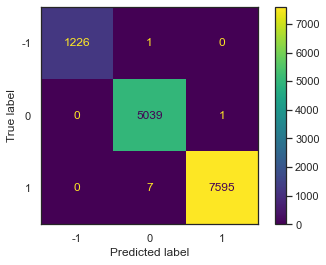

In [53]:
# Classification report
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
y_pred_train = mygrid_trainset.predict(X_train)



y_train = y_train
sns.set_theme(style='white')
def class_report(model,y_train,y_pred_train):
    print(classification_report(y_train,y_pred_train))
    cm = confusion_matrix(y_train,y_pred_train,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    disp.figure_.savefig('model_doc2vec_200_img/confusion_matrix_no_PCA_df_clean.png',dpi=300)


class_report(mygrid_trainset,y_train,y_pred_train)

**ROC on training data**

In [54]:
knn =KNeighborsClassifier(leaf_size=10, n_neighbors=6,
                                      weights='distance')

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

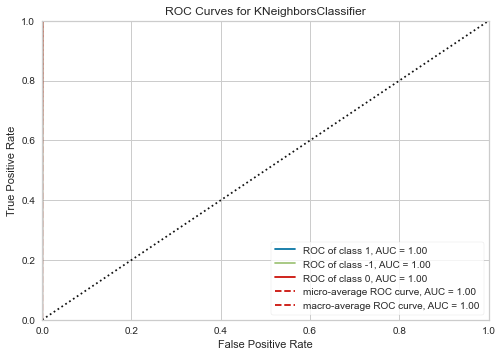

In [55]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(knn, classes=[-1,0,1])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_train, y_train)        # Evaluate the model on the training data
visualizer.show(outpath="model_doc2vec_200_img/roc_without_PCA_df_clean.png")
# Without PCA: AUC score using OvR, macro-averaged over all classes: 1.00

A big leap in performnce of AUC macro and f1-score while changing the value of alpha (0.05->0.5) does have an effect on performance.
The introduction of dm_mean contributed to performance.

**Building the model with best estimator and testing on test data**

In [59]:
knn =KNeighborsClassifier(leaf_size=10, n_neighbors=6,
                                      weights='distance')

knn.fit(X_train,y_train)

KNeighborsClassifier(leaf_size=10, n_neighbors=6, weights='distance')

              precision    recall  f1-score   support

          -1       0.42      0.23      0.30       307
           0       0.50      0.46      0.48      1260
           1       0.63      0.71      0.67      1901

    accuracy                           0.58      3468
   macro avg       0.52      0.47      0.48      3468
weighted avg       0.57      0.58      0.57      3468



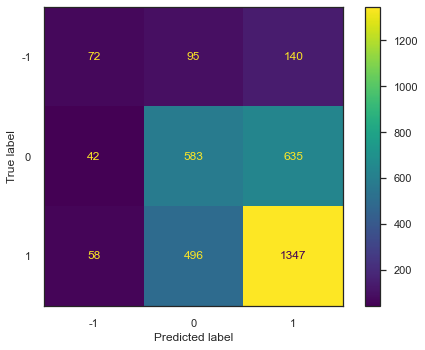

In [60]:
# Classification report test data
y_test = y_test
y_pred_test = knn.predict(X_test)
sns.set_theme(style='white')
def class_report(model,y_test,pred):
    print(classification_report(y_test,pred))
    cm = confusion_matrix(y_test,pred,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    disp.figure_.savefig('model_doc2vec_200_img/confusion_matrix_test_data_no_PCA_df_clean.png',dpi=300)


class_report(knn,y_test,y_pred_test)

**ROC on test data**

In [61]:
knn =KNeighborsClassifier(leaf_size=10, n_neighbors=6,
                                      weights='distance')

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

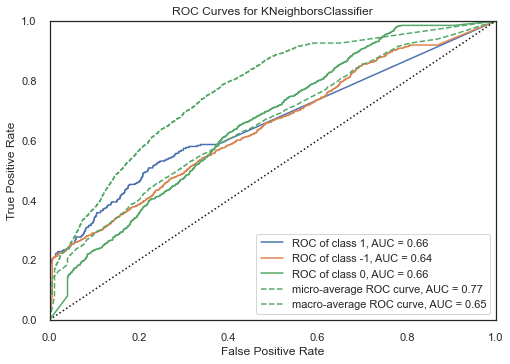

In [62]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(knn, classes=[-1,0,1])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)          # Evaluate the model on the training data
visualizer.show(outpath="model_doc2vec_200_img/roc_test_data_without_PCA_df_clean.png")
# Without PCA: AUC score using OvR, macro-averaged over all classes: 0.85

## **Conclusion**

- A total drop in performance for both AUC macro (0.85-> 0.65) and in f1-score macro (0.67-> 0.48)  in test data. 
- A high learning rate will in fact lead to terrible model pperformance.


**Table of Values**

dataset|f1_score_macro_avg|AUC_score_avg
| ----------- | ----------- | ----------- |
df_clean_(train data)|1.00|1.00
df_clean (test data)|0.48|0.65